In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datasets import load_dataset

dataset = load_dataset("Bingsu/Human_Action_Recognition", split='train')

Generating test split: 100%|██████████| 5400/5400 [00:00<00:00, 13307.50 examples/s]


In [3]:
dataset = dataset.shuffle().train_test_split(test_size=0.2)

In [4]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=284x177>,
 'labels': 11}

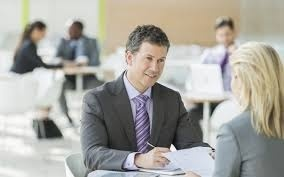

In [5]:
dataset['train'][0]['image']

In [6]:
labels = dataset['train'].features['labels'].names

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'calling': 0, 'clapping': 1, 'cycling': 2, 'dancing': 3, 'drinking': 4, 'eating': 5, 'fighting': 6, 'hugging': 7, 'laughing': 8, 'listening_to_music': 9, 'running': 10, 'sitting': 11, 'sleeping': 12, 'texting': 13, 'using_laptop': 14}
{0: 'calling', 1: 'clapping', 2: 'cycling', 3: 'dancing', 4: 'drinking', 5: 'eating', 6: 'fighting', 7: 'hugging', 8: 'laughing', 9: 'listening_to_music', 10: 'running', 11: 'sitting', 12: 'sleeping', 13: 'texting', 14: 'using_laptop'}


## Image Preprocessing

In [7]:
from transformers import AutoImageProcessor #-> like Tokenizer

model_ckpt = "google/vit-base-patch16-224-in21k"
# model_ckpt = "microsoft/swinv2-tiny-patch4-window16-256"

In [8]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

image_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (image_processor.size['shortest_edge'] if 'shortest_edge' in image_processor.size 
        else (image_processor.size['height'], image_processor.size['width']))

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transforms(batch):
    batch['pixel_values'] = [_transforms(img.convert('RGB')) for img in batch['image']]

    del batch['image']

    return batch

In [9]:
dataset = dataset.with_transform(transforms)

## Evaluate the model


In [10]:
# !pip install evaluate

import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## Vision Transformer (ViT) Fine Tuning for Image Classification

In [11]:
from transformers import AutoModelForImageClassification
import torch

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = AutoModelForImageClassification.from_pretrained(
    model_ckpt,
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id
).to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
len(labels)

15

## Model Training

In [14]:
from transformers import TrainingArguments, Trainer


args = TrainingArguments(
    output_dir="train_dir",
    remove_unused_columns=False,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)


trainer = Trainer(
    model = model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics
)

In [ ]:
# Do training on Google Colab
# trainer.train()

In [18]:
# trainer.evaluate()

In [34]:
trainer.save_model('vit-human-pose-classification')

## Classification Report and Confusion Matrix

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
logits = trainer.predict(dataset['test'])

In [59]:
logits = logits.predictions

In [61]:
y_pred = np.argmax(logits, axis=1)

In [67]:
y_true = [x['labels'] for x in dataset['test']]

In [69]:
print(classification_report(y_true, y_pred, target_names=labels))

                    precision    recall  f1-score   support

           calling       0.63      0.74      0.68       144
          clapping       0.77      0.76      0.76       170
           cycling       0.95      0.93      0.94       178
           dancing       0.77      0.81      0.79       163
          drinking       0.82      0.77      0.79       177
            eating       0.87      0.86      0.86       168
          fighting       0.82      0.77      0.79       170
           hugging       0.75      0.81      0.78       186
          laughing       0.76      0.79      0.77       156
listening_to_music       0.80      0.67      0.73       181
           running       0.85      0.81      0.83       180
           sitting       0.57      0.71      0.63       134
          sleeping       0.89      0.80      0.84       176
           texting       0.63      0.63      0.63       171
      using_laptop       0.75      0.75      0.75       166

          accuracy                    

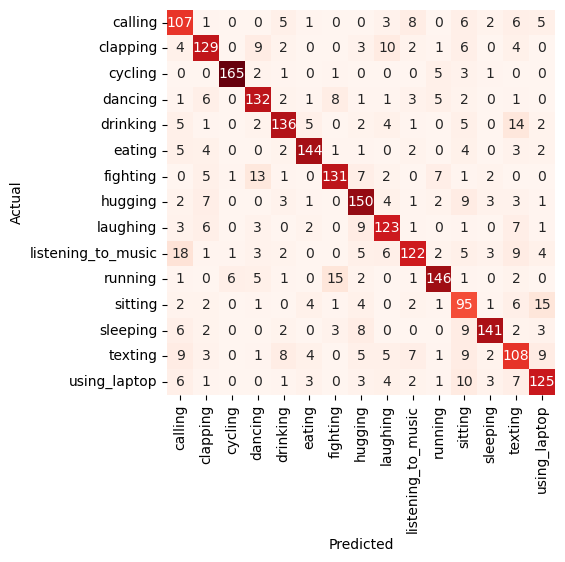

In [73]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Prediction on Real Image

In [23]:
from transformers import pipeline
from transformers import AutoImageProcessor

model_ckpt = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)

pipe = pipeline('image-classification', model='vit-human-pose-classification', 
                image_processor=image_processor)

url = "https://images.pexels.com/photos/1755385/pexels-photo-1755385.jpeg"

output = pipe(url)
output

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'sitting', 'score': 0.9056419134140015},
 {'label': 'using_laptop', 'score': 0.7536187171936035},
 {'label': 'sleeping', 'score': 0.5721868276596069},
 {'label': 'texting', 'score': 0.5402078032493591},
 {'label': 'listening_to_music', 'score': 0.4892818331718445}]

In [2]:
image_processor.save_pretrained('vit-human-pose-classification')

['vit-human-pose-classification\\preprocessor_config.json']

In [22]:
# Load the model and image processor from the local directory
from transformers import AutoImageProcessor, AutoModel

local_directory = 'vit-human-pose-classification'
image_processor = AutoImageProcessor.from_pretrained(local_directory, use_fast=True)
model = AutoModel.from_pretrained(local_directory, local_files_only=True)

Some weights of ViTModel were not initialized from the model checkpoint at vit-human-pose-classification and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
